# Importando bibliotecas:

In [1]:
# Importando os utilitarios
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import warnings
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.metrics import confusion_matrix

# Importando os modelos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Carregando os dados:

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
caminho_dataset = '/content/drive/MyDrive/fraud_detection_dataset.csv'

dados_panda = pd.read_csv(caminho_dataset)

# Exibindo as primeiras linhas do DataFrame para verificar se foi carregado corretamente
print(dados_panda.head())

             timestamp                               user_id  amount  \
0  2023-12-15 02:48:24  3cbf0b8a-c799-4c0e-9782-89272ab8fa2b  998.99   
1  2023-10-30 11:08:37  3675ed98-6863-4bae-b089-6f0db2df006b  241.39   
2  2023-11-21 05:19:35  4be1043f-20ee-4ac5-a689-b25c6a1de50c  836.42   
3  2023-11-07 00:03:25  cad0b3c9-099f-479b-8043-6d5ecb4e1467  612.74   
4  2023-04-02 14:12:23  b6ebea7d-ba62-41d7-b042-3978a23fef8b  135.55   

          location device_type  is_fraud  age     income      debt  \
0        Grantfurt      Mobile         0   56   42524.98   8394.05   
1  Kimberlychester      Tablet         0   52   69884.04  28434.06   
2   Gutierrezville     Desktop         0   58  126953.62  39121.78   
3         Markside     Desktop         0   19  128650.70  39652.48   
4     Anthonyshire      Tablet         0   59  102020.39   7439.81   

   credit_score  
0           655  
1           395  
2           496  
3           612  
4           302  


# Tratando os dados:

In [4]:
# buscando por duplicatas:
print(dados_panda.duplicated().sum())
print()

# removendo as duplicatas:
dados_panda = dados_panda.drop_duplicates()

# buscando novamente:
print(dados_panda.duplicated().sum())

0

0


In [5]:
dados_panda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 10 columns):
 #   Column        Dtype  
---  ------        -----  
 0   timestamp     object 
 1   user_id       object 
 2   amount        float64
 3   location      object 
 4   device_type   object 
 5   is_fraud      int64  
 6   age           int64  
 7   income        float64
 8   debt          float64
 9   credit_score  int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 152.6+ MB


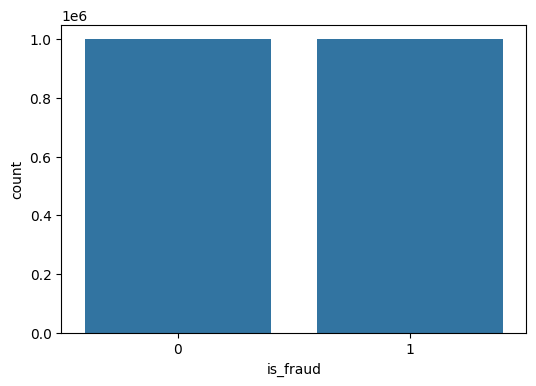

In [6]:
# Verificando o balanceamento das labels:
plt.figure(figsize=(6,4))
sns.countplot(x='is_fraud', data=dados_panda)
plt.show()

In [7]:
# Converter timestamp para características numéricas
dados_panda['timestamp'] = pd.to_datetime(dados_panda['timestamp'])
dados_panda['year'] = dados_panda['timestamp'].dt.year
dados_panda['month'] = dados_panda['timestamp'].dt.month
dados_panda['day_of_week'] = dados_panda['timestamp'].dt.dayofweek
dados_panda['hour'] = dados_panda['timestamp'].dt.hour

print(dados_panda.head())

            timestamp                               user_id  amount  \
0 2023-12-15 02:48:24  3cbf0b8a-c799-4c0e-9782-89272ab8fa2b  998.99   
1 2023-10-30 11:08:37  3675ed98-6863-4bae-b089-6f0db2df006b  241.39   
2 2023-11-21 05:19:35  4be1043f-20ee-4ac5-a689-b25c6a1de50c  836.42   
3 2023-11-07 00:03:25  cad0b3c9-099f-479b-8043-6d5ecb4e1467  612.74   
4 2023-04-02 14:12:23  b6ebea7d-ba62-41d7-b042-3978a23fef8b  135.55   

          location device_type  is_fraud  age     income      debt  \
0        Grantfurt      Mobile         0   56   42524.98   8394.05   
1  Kimberlychester      Tablet         0   52   69884.04  28434.06   
2   Gutierrezville     Desktop         0   58  126953.62  39121.78   
3         Markside     Desktop         0   19  128650.70  39652.48   
4     Anthonyshire      Tablet         0   59  102020.39   7439.81   

   credit_score  year  month  day_of_week  hour  
0           655  2023     12            4     2  
1           395  2023     10            0    11  
2 

In [8]:
# Criar um codificador one-hot
encoder = OneHotEncoder()

# Ajustar e transformar os dados
encoded_data = encoder.fit_transform(dados_panda[['device_type']])

# Converter os resultados em um DataFrame do Pandas
encoded_df = pd.DataFrame(encoded_data.toarray(), columns=encoder.get_feature_names_out(['device_type'])).astype(int)

encoded_df.rename(columns={'device_type_Desktop': 'Desktop', 'device_type_Mobile': 'Mobile', 'device_type_Tablet': 'Tablet'}, inplace=True)

print(encoded_df.head())

   Desktop  Mobile  Tablet
0        0       1       0
1        0       0       1
2        1       0       0
3        1       0       0
4        0       0       1


In [9]:
dados_panda['Desktop'] = encoded_df['Desktop']
dados_panda['Mobile'] = encoded_df['Mobile']
dados_panda['Tablet'] = encoded_df['Tablet']

print(dados_panda.head())

            timestamp                               user_id  amount  \
0 2023-12-15 02:48:24  3cbf0b8a-c799-4c0e-9782-89272ab8fa2b  998.99   
1 2023-10-30 11:08:37  3675ed98-6863-4bae-b089-6f0db2df006b  241.39   
2 2023-11-21 05:19:35  4be1043f-20ee-4ac5-a689-b25c6a1de50c  836.42   
3 2023-11-07 00:03:25  cad0b3c9-099f-479b-8043-6d5ecb4e1467  612.74   
4 2023-04-02 14:12:23  b6ebea7d-ba62-41d7-b042-3978a23fef8b  135.55   

          location device_type  is_fraud  age     income      debt  \
0        Grantfurt      Mobile         0   56   42524.98   8394.05   
1  Kimberlychester      Tablet         0   52   69884.04  28434.06   
2   Gutierrezville     Desktop         0   58  126953.62  39121.78   
3         Markside     Desktop         0   19  128650.70  39652.48   
4     Anthonyshire      Tablet         0   59  102020.39   7439.81   

   credit_score  year  month  day_of_week  hour  Desktop  Mobile  Tablet  
0           655  2023     12            4     2        0       1       0  
1 

In [10]:
num_valores_unicos = dados_panda['user_id'].nunique()
print(num_valores_unicos)

2000000


In [11]:
dados_panda.drop('device_type', axis=1, inplace=True)
dados_panda.drop('timestamp', axis=1, inplace=True)
dados_panda.drop('user_id', axis=1, inplace=True)

In [12]:
print(dados_panda.head())

   amount         location  is_fraud  age     income      debt  credit_score  \
0  998.99        Grantfurt         0   56   42524.98   8394.05           655   
1  241.39  Kimberlychester         0   52   69884.04  28434.06           395   
2  836.42   Gutierrezville         0   58  126953.62  39121.78           496   
3  612.74         Markside         0   19  128650.70  39652.48           612   
4  135.55     Anthonyshire         0   59  102020.39   7439.81           302   

   year  month  day_of_week  hour  Desktop  Mobile  Tablet  
0  2023     12            4     2        0       1       0  
1  2023     10            0    11        0       0       1  
2  2023     11            1     5        1       0       0  
3  2023     11            1     0        1       0       0  
4  2023      4            6    14        0       0       1  


In [13]:
print(dados_panda['location'].nunique())

104592


In [14]:
# Calcula a frequência de cada localização
freq = dados_panda['location'].value_counts(normalize=False)

print(freq)

location
East Michael          1713
Lake Michael          1702
New Michael           1626
Port Michael          1624
West Michael          1604
                      ... 
South Jaymouth           1
North Beckytown          1
New Caitlinshire         1
North Beckyborough       1
Port Miguelport          1
Name: count, Length: 104592, dtype: int64


In [15]:
# Crie um dicionário com os valores da frequência
freq_dict = freq.to_dict()

# Substitua a frequência na coluna 'location'
dados_panda['location'] = dados_panda['location'].map(freq_dict)

print(dados_panda['location'])

0           40
1          223
2           58
3          197
4          178
          ... 
1999995     35
1999996    418
1999997     19
1999998     13
1999999     33
Name: location, Length: 2000000, dtype: int64


In [16]:
dados_panda.rename(columns={'location': 'location_freq', 'income':'anual_salary'}, inplace=True)
print(dados_panda.head())

   amount  location_freq  is_fraud  age  anual_salary      debt  credit_score  \
0  998.99             40         0   56      42524.98   8394.05           655   
1  241.39            223         0   52      69884.04  28434.06           395   
2  836.42             58         0   58     126953.62  39121.78           496   
3  612.74            197         0   19     128650.70  39652.48           612   
4  135.55            178         0   59     102020.39   7439.81           302   

   year  month  day_of_week  hour  Desktop  Mobile  Tablet  
0  2023     12            4     2        0       1       0  
1  2023     10            0    11        0       0       1  
2  2023     11            1     5        1       0       0  
3  2023     11            1     0        1       0       0  
4  2023      4            6    14        0       0       1  


# Análise exploratória de dados:

In [17]:
print("Informações gerais sobre o dataframe:")
print()
print(dados_panda.info())

Informações gerais sobre o dataframe:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 14 columns):
 #   Column         Dtype  
---  ------         -----  
 0   amount         float64
 1   location_freq  int64  
 2   is_fraud       int64  
 3   age            int64  
 4   anual_salary   float64
 5   debt           float64
 6   credit_score   int64  
 7   year           int32  
 8   month          int32  
 9   day_of_week    int32  
 10  hour           int32  
 11  Desktop        int64  
 12  Mobile         int64  
 13  Tablet         int64  
dtypes: float64(3), int32(4), int64(7)
memory usage: 183.1 MB
None


In [18]:
# Estatísticas descritivas das variáveis numéricas
print("Estatísticas descritivas das variáveis numéricas:")
print()
print(dados_panda.describe())

Estatísticas descritivas das variáveis numéricas:

             amount  location_freq   is_fraud           age  anual_salary  \
count  2.000000e+06   2.000000e+06  2000000.0  2.000000e+06  2.000000e+06   
mean   1.751680e+03   1.614969e+02        0.5  4.400430e+01  8.502099e+04   
std    1.504160e+03   2.415426e+02        0.5  1.529754e+01  3.753201e+04   
min    1.000000e+01   1.000000e+00        0.0  1.800000e+01  2.000009e+04   
25%    5.043400e+02   2.000000e+01        0.0  3.100000e+01  5.253058e+04   
50%    1.000005e+03   6.100000e+01        0.5  4.400000e+01  8.503287e+04   
75%    2.996710e+03   1.960000e+02        1.0  5.700000e+01  1.175375e+05   
max    4.999990e+03   1.713000e+03        1.0  7.000000e+01  1.500000e+05   

               debt  credit_score          year         month   day_of_week  \
count  2.000000e+06  2.000000e+06  2.000000e+06  2.000000e+06  2.000000e+06   
mean   2.498404e+04  5.747856e+02  2.023164e+03  6.518742e+00  2.999412e+00   
std    1.444005e+0

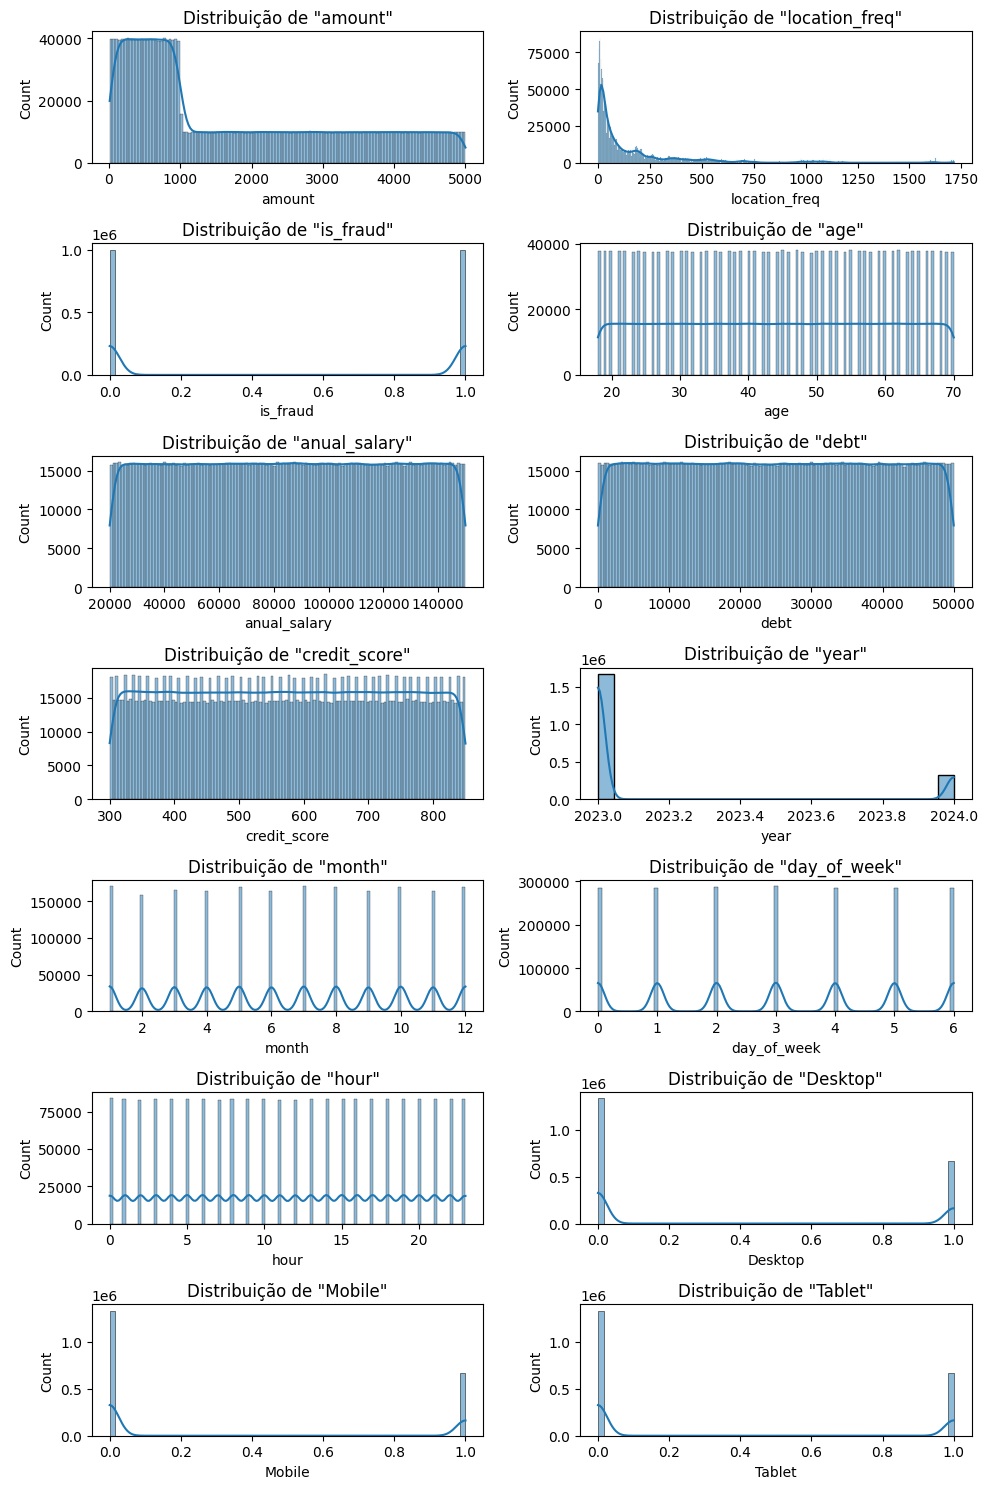

In [19]:
# Definindo o tamanho da grade
num_rows = 7
num_cols = 2

# Criando a figura e os eixos
fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 15))

# Variáveis a serem plotadas
variaveis = dados_panda.columns

# Loop sobre as variáveis
for i, var in enumerate(variaveis):
    row = i // num_cols
    col = i % num_cols

    # Plotando a distribuição
    sns.histplot(dados_panda[var], ax=axs[row, col], kde=True)
    axs[row, col].set_title(f'Distribuição de "{var}"')

# Ajustando o layout
plt.tight_layout()
plt.show()

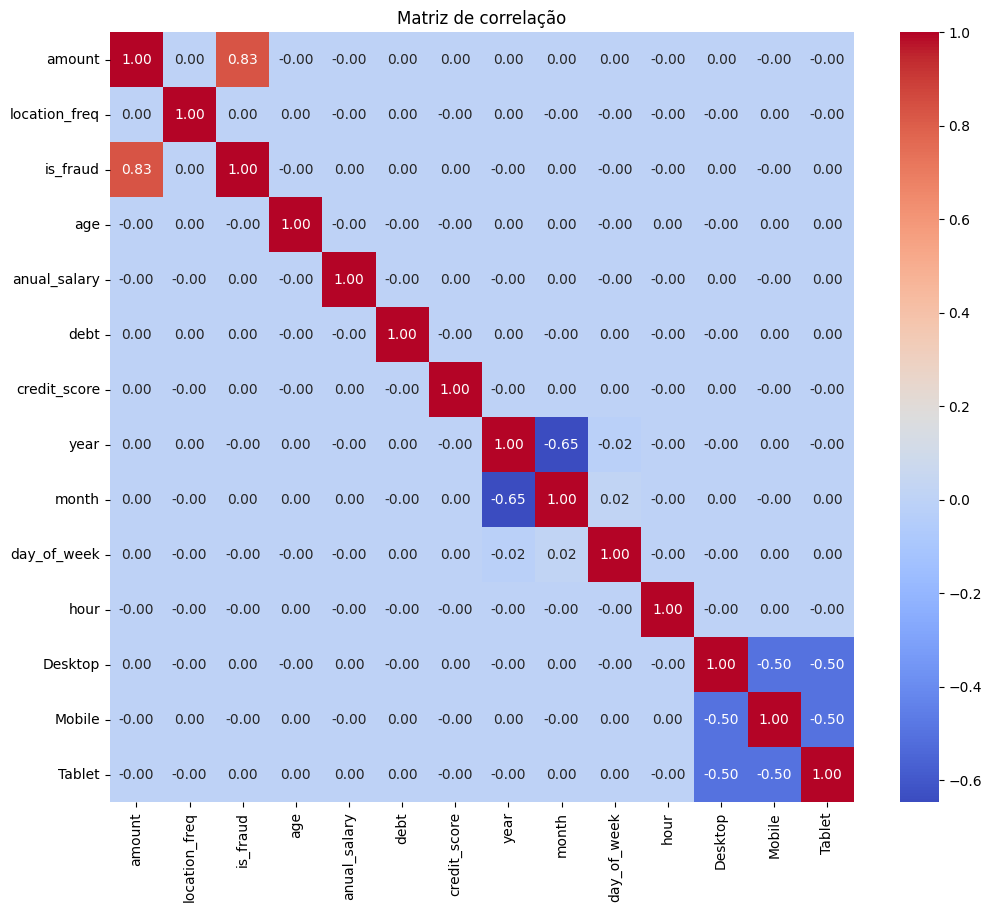

In [20]:
# Correlação entre variáveis
correlation_matrix = dados_panda.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de correlação')
plt.show()

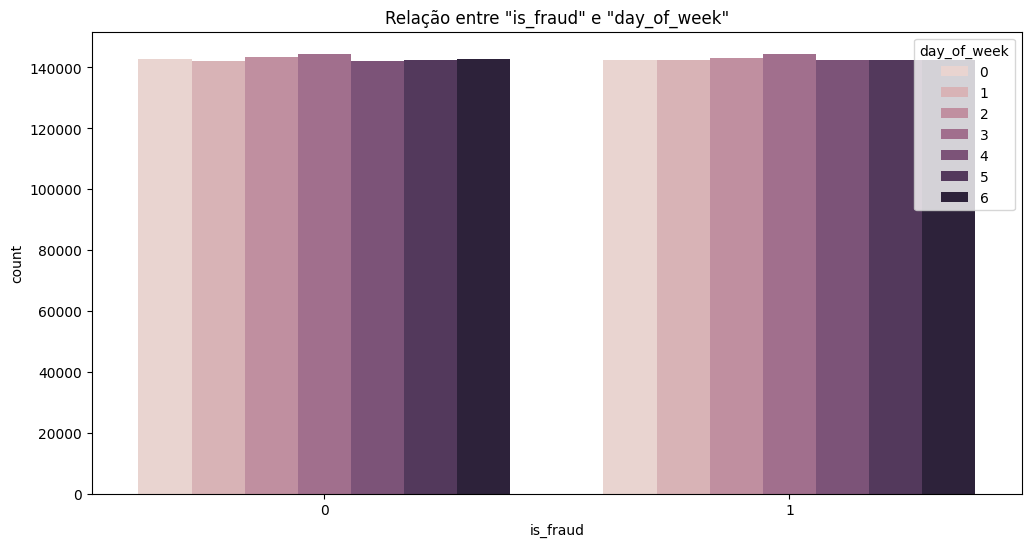

In [21]:
# Visualização da relação entre variáveis categóricas e a variável de destino
plt.figure(figsize=(12, 6))
sns.countplot(x='is_fraud', hue='day_of_week', data=dados_panda)
plt.title('Relação entre "is_fraud" e "day_of_week"')
plt.show()

# Normalização dos dados:

In [22]:
# Inicialize o MinMaxScaler
scaler = MinMaxScaler()

dados_normalizados = scaler.fit_transform(dados_panda)

# Converta de volta para DataFrame
dados_normalizados = pd.DataFrame(dados_normalizados, columns=dados_panda.columns)

print(dados_normalizados.head())

     amount  location_freq  is_fraud       age  anual_salary      debt  \
0  0.198195       0.022780       0.0  0.730769      0.173269  0.167880   
1  0.046371       0.129673       0.0  0.653846      0.383723  0.568681   
2  0.165616       0.033294       0.0  0.769231      0.822720  0.782436   
3  0.120790       0.114486       0.0  0.019231      0.835775  0.793050   
4  0.025160       0.103388       0.0  0.788462      0.630926  0.148796   

   credit_score  year     month  day_of_week      hour  Desktop  Mobile  \
0      0.645455   0.0  1.000000     0.666667  0.086957      0.0     1.0   
1      0.172727   0.0  0.818182     0.000000  0.478261      0.0     0.0   
2      0.356364   0.0  0.909091     0.166667  0.217391      1.0     0.0   
3      0.567273   0.0  0.909091     0.166667  0.000000      1.0     0.0   
4      0.003636   0.0  0.272727     1.000000  0.608696      0.0     0.0   

   Tablet  
0     0.0  
1     1.0  
2     0.0  
3     0.0  
4     1.0  


# Divisão dos conjuntos de treino e teste:

In [23]:
# Dividir o dataframe em variáveis independentes (X) e variável dependente (y)
X = dados_normalizados.drop(columns=['is_fraud'])
y = dados_normalizados['is_fraud']

In [24]:
# Dividir os dados em conjuntos de treino e teste (por exemplo, 80% para treino e 20% para teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# Exibir os tamanhos dos conjuntos de treino e teste
print("Tamanho do conjunto de treino:", X_train.shape[0])
print("Tamanho do conjunto de teste:", X_test.shape[0])

Tamanho do conjunto de treino: 1600000
Tamanho do conjunto de teste: 400000


In [26]:
print(X_train.iloc[0])

amount           0.162062
location_freq    0.011682
age              0.250000
anual_salary     0.751233
debt             0.396544
credit_score     0.840000
year             0.000000
month            1.000000
day_of_week      0.166667
hour             0.086957
Desktop          0.000000
Mobile           1.000000
Tablet           0.000000
Name: 399734, dtype: float64


# Realizando os treinamentos

In [27]:
# Instanciar os modelos:
modelo_regressao_logistica = LogisticRegression()
modelo_arvore_decisao = DecisionTreeClassifier()
modelo_floresta_decisao = RandomForestClassifier()


# Lista de modelos
modelos = [
    ("Regressão Logística", modelo_regressao_logistica),
    ("Árvore de Decisão", modelo_arvore_decisao),
    ("Floresta de Decisão", modelo_floresta_decisao)
]

In [28]:
# Iterar sobre cada modelo
for nome_modelo, modelo in modelos:
    print(f"Treinando modelo {nome_modelo}...")
    inicio = time.time()
    modelo.fit(X_train, y_train)  # Treinar o modelo
    fim = time.time()
    tempo_decorrido = fim - inicio
    print(f"Tempo de treinamento: {tempo_decorrido:.2f} segundos\n")

Treinando modelo Regressão Logística...
Tempo de treinamento: 10.85 segundos

Treinando modelo Árvore de Decisão...
Tempo de treinamento: 3.09 segundos

Treinando modelo Floresta de Decisão...
Tempo de treinamento: 213.41 segundos



# Testando cada modelo:

In [29]:
def plotagem(conf_matrix):
    # Plotar a matriz de confusão
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes.values(), yticklabels=classes.values())
    plt.xlabel('Valores Preditos')
    plt.ylabel('Valores Reais')
    plt.title(f'Matriz de Confusão - Modelo {nome_modelo}')
    plt.show()

Testando modelo Regressão Logística...
Métricas de classificação para Regressão Logística:
Acurácia: 0.9960
Precisão: 1.0000
Recall: 0.9920
F1: 0.9960
Matriz de confusão:


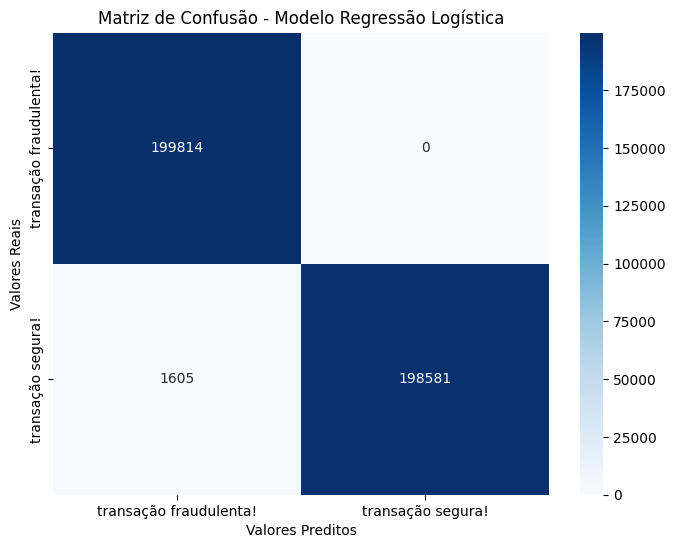

Tempo de teste: 0.02 segundos

Testando modelo Árvore de Decisão...
Métricas de classificação para Árvore de Decisão:
Acurácia: 1.0000
Precisão: 1.0000
Recall: 1.0000
F1: 1.0000
Matriz de confusão:


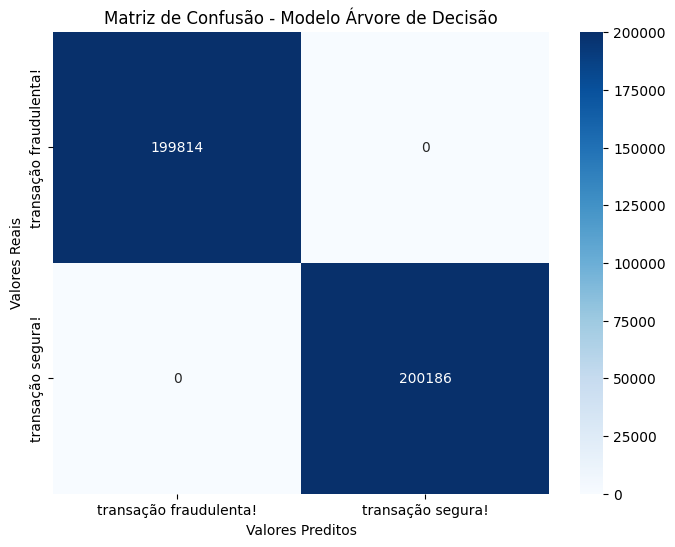

Tempo de teste: 0.04 segundos

Testando modelo Floresta de Decisão...
Métricas de classificação para Floresta de Decisão:
Acurácia: 1.0000
Precisão: 1.0000
Recall: 1.0000
F1: 1.0000
Matriz de confusão:


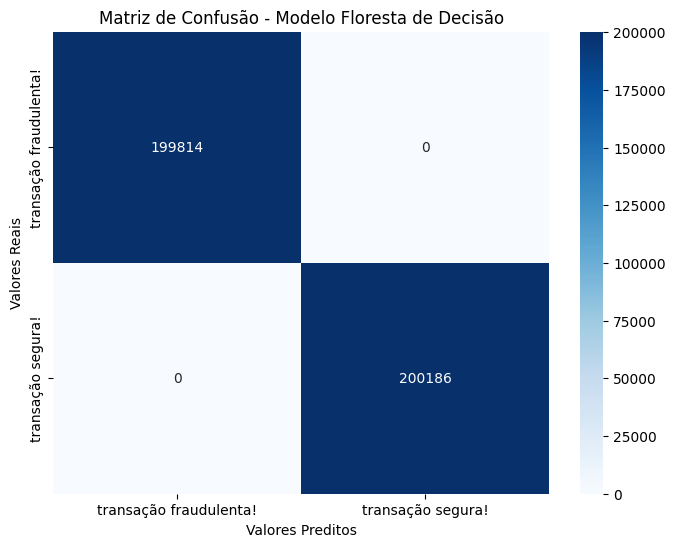

Tempo de teste: 3.24 segundos



In [30]:
classes = {
    1.0: "transação fraudulenta!",
    0.0: "transação segura!"
}

# Iterar sobre cada modelo
for nome_modelo, modelo in modelos:
    print(f"Testando modelo {nome_modelo}...")
    inicio = time.time()  # Marcar o tempo de início do teste
    y_pred = modelo.predict(X_test)  # Fazer previsões nos dados de teste
    fim = time.time()  # Marcar o tempo de término do teste
    tempo_decorrido = fim - inicio  # Calcular o tempo decorrido

    # Avaliar o desempenho do modelo
    acuracia = accuracy_score(y_test, y_pred)
    precisao = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(f"Métricas de classificação para {nome_modelo}:")
    print(f"Acurácia: {acuracia:.4f}")
    print(f"Precisão: {precisao:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1: {f1:.4f}")
    print("Matriz de confusão:")
    plotagem(conf_matrix)
    print(f"Tempo de teste: {tempo_decorrido:.2f} segundos\n")

# Inferências sobre dados unitários:

In [31]:
# desativar as mensagens de aviso
warnings.filterwarnings("ignore")

def inferir_e_mostrar_predicao(modelos, X_test, y_test, classes):
    # Escolher aleatoriamente um índice do conjunto de dados de teste
    indice_amostra = np.random.randint(0, len(X_test))

    # Obter a amostra de teste e sua classe verdadeira correspondente
    amostra_teste = X_test.iloc[indice_amostra]
    classe_verdadeira = y_test.iloc[indice_amostra]

    print(f"Amostra de Teste \n: {amostra_teste}")
    print()

    # Iterar sobre cada modelo
    for nome_modelo, modelo in modelos:
        # Realizar a previsão com o modelo atual
        classe_predita = modelo.predict([amostra_teste])[0]

        # Imprimir a classe verdadeira e a classe predita para este modelo
        print(f"Modelo: {nome_modelo}")
        print(f"Label: {classes[classe_verdadeira]}")
        print(f"Predito: {classes[classe_predita]}\n")

# Exemplo de uso da função
inferir_e_mostrar_predicao(modelos, X_test, y_test, classes)

Amostra de Teste 
: amount           0.608340
location_freq    0.002921
age              0.096154
anual_salary     0.185544
debt             0.303826
credit_score     0.283636
year             0.000000
month            0.727273
day_of_week      0.666667
hour             0.347826
Desktop          1.000000
Mobile           0.000000
Tablet           0.000000
Name: 1510194, dtype: float64

Modelo: Regressão Logística
Label: transação fraudulenta!
Predito: transação fraudulenta!

Modelo: Árvore de Decisão
Label: transação fraudulenta!
Predito: transação fraudulenta!

Modelo: Floresta de Decisão
Label: transação fraudulenta!
Predito: transação fraudulenta!

